<a href="https://colab.research.google.com/github/tabaraei/aspect-based-sentiment-analysis/blob/main/ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Born and explanations provided to understand why the opinion is positive or negative, and at the end compare it with pre-trained model.

[Born Classifier](https://bornrule.eguidotti.com) is a text classification algorithm inspired by the notion of superposition of states in quantum
physics. Born provides good classification performance, explainability, and computational efficiency. In this
project, the goal is to exploit the Born explanation in order to use it for Aspect Based Sentiment Analysis. In
particular, the main idea to to proceed as follows:
1. Perform a sentiment analysis classification of documents using Born
2. Extract the explanation features for each pair of documents and predicted labels
3. Analyze the explanatory features in order to group them in candidate aspects
4. Associate each aspect to a specific sentence or portion of the text
5. Predict the sentiment for the sentence or text portion using the trained Born classifier
6. Associate then a (potentially different) sentiment to each sentence or text portion according to the aspect
7. Finally, evaluate the quality of the results for each aspect.

## Dataset

Any dataset supporting ABSA. See for example [here](https://paperswithcode.com/datasets?task=aspect-based-sentiment-analysis&page=1).

In [22]:
%%capture
!pip install datasets

from datasets import load_dataset
import pandas as pd

In [37]:
def compute_overall_sentiment(aspect_sentiments):
    pos_count = aspect_sentiments.count('positive')
    neg_count = aspect_sentiments.count('negative')

    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

def create_dataset(dataset):
    data = []
    for entry in dataset:
        document = entry['text']
        aspects = [aspect['term'] for aspect in entry['aspectTerms']]
        aspect_sentiments = [aspect['polarity'] for aspect in entry['aspectTerms']]
        overall_sentiment = compute_overall_sentiment(aspect_sentiments)
        data.append({
            'document': document,
            'aspects': aspects,
            'aspect_sentiments': aspect_sentiments,
            'overall_sentiment': overall_sentiment
        })
    return pd.DataFrame(data)

In [38]:
# Load the "restaurants" or "laptops" datasets from SemEval2014 in HuggingFace
dataset = load_dataset('alexcadillon/SemEval2014Task4', 'restaurants')
train_data, test_data = dataset['train'], dataset['test']

# Transform the data
train_df = create_dataset(train_data)
test_df = create_dataset(test_data)

# Show a sample of the data
print(f'Train size: {train_data.shape}, Test size: {test_data.shape}')
train_df.head()

Train size: (3041, 4), Test size: (800, 4)


,document,aspects,aspect_sentiments,overall_sentiment
0,But the staff was so horrible to us.,[staff],[negative],negative
1,"To be completely fair, the only redeeming fact...",[food],[positive],positive
2,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]",positive
3,Where Gabriela personaly greets you and recomm...,[],[],neutral
4,"For those that go once and don't enjoy it, all...",[],[],neutral


## NLTK

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

_ = nltk.download('vader_lexicon', quiet=True)
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_analyzer.polarity_scores(sample_text)

{'neg': 0.0, 'neu': 0.266, 'pos': 0.734, 'compound': 0.8516}

## RoBERTa

In [ ]:
sample_text = "I love this product! It's amazing."

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
encoded_text = tokenizer(sample_text, return_tensors='pt')
output = model(**encoded_text)[0][0]
scores = softmax(output.detach().numpy())
neg, neu, pos = scores
scores

array([0.00212159, 0.00545376, 0.9924246 ], dtype=float32)

## Born

In [43]:
%%capture
!pip install bornrule

from bornrule import BornClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
import warnings

warnings.filterwarnings('ignore')
nltk.download('punkt_tab')

Create a sparse matrix where rows represent documents and columns represent unique tokens (words) in the vocabulary.

In [41]:
# Tokenization and Vectorization
vec = CountVectorizer(tokenizer=word_tokenize, lowercase=True, token_pattern=None)
X_train, y_train = vec.fit_transform(train_df['document']), train_df['overall_sentiment']
X_test, y_test = vec.transform(test_df['document']), test_df['overall_sentiment']

# Training the classifier
clf = BornClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

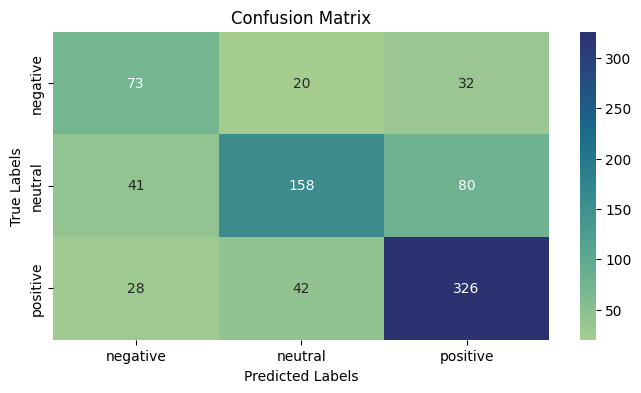

In [73]:
# Creating the Confusion Matrix
class_labels = sorted(train_df['overall_sentiment'].unique())
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=class_labels, yticklabels=class_labels)
_ = ax.set(xlabel='Predicted Labels', ylabel='True Labels', title='Confusion Matrix')

## Explanation

In [135]:
explainer = clf.explain()
explain = pd.DataFrame(explainer.toarray(), index=vec.get_feature_names_out(), columns=class_labels)

In [136]:
explain['positive'].sort_values(ascending=False).head()

,positive
friendly,0.034340
attentive,0.033205
reasonable,0.032684
great,0.030946
yummy,0.028073


In [137]:
explain['negative'].sort_values(ascending=False).head()

,negative
awful,0.034837
bland,0.029271
waiting,0.028652
lousy,0.026456
worst,0.026351


In [123]:
document, aspects, aspect_sentiments, overall_sentiment = train_df.iloc[0]
print(f'''Document: "{document}"
    Aspects: {aspects}
    Aspect Sentiments: {aspect_sentiments}
    Overall Sentiment: {overall_sentiment}''')

Document: "But the staff was so horrible to us."
    Aspects: ['staff']
    Aspect Sentiments: ['negative']
    Overall Sentiment: negative


## References

- Emanuele Guidotti and Alfio Ferrara. Text Classification with Born’s Rule. Advances in Neural Information
Processing Systems, 2022.
- Schouten, K., & Frasincar, F. (2015). Survey on aspect-level sentiment analysis. IEEE Transactions on
Knowledge and Data Engineering, 28(3), 813-830. [link](https://ieeexplore.ieee.org/document/7286808)
- Rana, T. A., & Cheah, Y. N. (2016). Aspect extraction in sentiment analysis: comparative analysis and survey.
Artificial Intelligence Review, 46(4), 459-483. [link](https://link.springer.com/article/10.1007/s10462-016-9472-z)